In [21]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle

from scipy.interpolate import griddata
import time

np.random.seed(1)

In [22]:
def plot_3d_scatter(points):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
    ax.set(xlabel="x", ylabel="y", zlabel="z")
    
    return fig, ax

## Overview

This jupyter notebook implements the plain time-consistent physics-informed neural network (tcPINN) idea for the Lorenz system.

The system reads

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} x \\ y \\ z \end{pmatrix} = \begin{pmatrix} 
    \sigma (y-x) \\ x(\rho -z) - y \\ xy - \beta z\end{pmatrix}.
\end{align*}

We set $\sigma = 10, \beta = \frac{8}{3}$ and $\rho = 28$, which is a choice of parameters known to exhibit chaotic behavior.

We normalize the attractor of the ODE system by shifting $x, y, z$ by $c_x, c_y$ and $c_z$ respectively and scaling all three components by $\lambda$. The normalized Lorenz system reads

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} x \\ y \\ z \end{pmatrix} = 
    \begin{pmatrix} 
    \sigma \big((y + \frac{c_y}{\lambda}) - (x + \frac{c_x}{\lambda})\big) \\
    \lambda (x + \frac{c_x}{\lambda}) (\frac{\rho}{\lambda} - (z + \frac{c_z}{\lambda})) - (y + \frac{c_y}{\lambda}) \\
    \lambda (x + \frac{c_x}{\lambda})(y + \frac{c_y}{\lambda}) - \beta (z + \frac{c_z}{\lambda}) 
    \end{pmatrix}.
\end{align*}

In [23]:
sigma = 10.
beta = 8 / 3
rho = 28.

# Note: These normalization factors were used to generate the training data
shift_x = - 0.013895
shift_y = - 0.013791
shift_z = 23.584181

scaling = 8.533635

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")

In [25]:
class MLP(torch.nn.Module):
    """
    Define an multilayer perceptron (MLP) with arbitrary layers and Tanh activation. 
    In the time-consistent physics informed neural network (tcPINN) implementation,
    the inputs of the MLP will correspond to the time and the initial state (t, 𝑦0).
    """    
    def __init__(self, layers):
        """
        Build the MLP.
        
        Input:
        ------
        layers: list
            A list that specifies the number of neurons for each layer.
            Entry i of 'list' specifies the number of neurons in layer i.
        """
        super().__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        
        for i in range(self.depth - 1):    
            layer_list.append(
                (f"layer_{i}", torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append((f"activation_{i}", self.activation()))
            
        layer_list.append(
            (f"layer_{self.depth - 1}", torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        """
        Apply the neural network to the input 'x'. In the tcPINN implementation,
        'x' = (t, y0), where t is the time and y0 is the initial state.
        """
        return self.layers(x)

In [26]:
class TcPINN:
    """
    A tcPINN implementation for the (scaled) Lorenz system.
    """
    def __init__(self, layers, T, X_pinn=None, X_semigroup=None, X_smooth=None, X_data=None, data=None):
        """
        Initialize the MLP and the training data. It is possible to use a subset of the 
        four loss functions {standard PINN loss, semigroup loss, smoothness loss, data loss} by
        only providing some of the training data.
        
        Input:
        ------
        layers: list
            A list that specifies the number of neurons for each layer of the MLP.
            Entry i of 'list' specifies the number of neurons in layer i.
        
        T: float
            The supremum of all times in the training data. When predicting the solution of
            the ODE after time T, the trajectory has to be stitched together.
        
        X_pinn: np.ndarray
            The training data for the standard PINN loss. The first column of 'X_pinn'
            corresponds to the times, the other columns correspond to the intial values.
        
        X_semigroup: np.ndarray
            The training data for the semigroup loss. The first column of 'X_semigroup'
            corresponds to the length of the first time step, the second to the length of the
            second time step, and the other columns correspond to the intial values.
        
        X_smooth: np.ndarray
            The training data for the smoothness loss. The first column of 'X_smooth'
            corresponds to the times, the other columns correspond to the intial values.
        
        X_data: np.ndarray
            The training data for the data loss. The first column of 'X_data'
            corresponds to the times, the other columns correspond to the intial values.
        
        data: np.ndarray
            The measured/true values of the ODE for the times and initial values given by
            'X_data'.
        """
        self.mlp = MLP(layers).to(device)
        self.ode_dimension = layers[-1]
        
        self.optimizer = torch.optim.LBFGS(
            self.mlp.parameters(), lr=1., max_iter=50000, max_eval=50000, 
            history_size=10, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', min_lr=1e-4, verbose=True
        )
        self.iter = 0
        
        self.T = torch.tensor(T).float().to(device)
        self._init_training_data(X_pinn, X_semigroup, X_smooth, X_data, data)
    
    
    def _init_training_data(self, X_pinn, X_semigroup, X_smooth, X_data, data):
        
        if X_pinn is not None:
            self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
            self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
            self.use_standard = True
        
        else:
            self.use_standard = False
        
        if X_semigroup is not None:
            self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
            self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
            self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
            self.use_semigroup = True
        
        else:
            self.use_semigroup = False
        
        if X_smooth is not None:
            self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
            self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
            self.use_smooth = True
        
        else:
            self.use_smooth = False
        
        if X_data is not None:
            if data is None:
                raise ValueError("The true/measured solution for the 'X_data' points has to be provided.")
            self.t_data = torch.tensor(X_data[:, :1], requires_grad=True).float().to(device)
            self.y_data = torch.tensor(X_data[:, 1:], requires_grad=True).float().to(device)
            self.data = torch.tensor(data, requires_grad=True).float().to(device)
            self.use_data = True
        
        else:
            self.use_data = False
    
    
    def net_y(self, t, y0):
        """
        Let N(t, y0) denote the value of the MLP at time t for initial value y0.
        Let M(t, y0) denote the value of the tcPINN at time t for initial value y0.
        
        We set M(t, y0) = y0 + t * N(t, y0) to guarantee continuity of the trajectory
        when stitching together solutions for large times.
        """
        y = y0 + t * self.mlp(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivatives of the neural network
        with respect to time.
        
        Output:
        -------
        derivatives: list
            The i-th entry is the time derivative of the i-th output component of the neural network
            evaluated at all inputs (t, y0). Each input corresponds to one row in each tensor.
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output component
        vectors = [torch.zeros_like(y) for _ in range(self.ode_dimension)]
        
        for i, vec in enumerate(vectors):
            vec[:,i] = 1.
        
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def _loss_pinn(self):
        """
        The ODE-specific standard PINN loss.
        """
        y = self.net_y(self.t_pinn, self.y_pinn)
        deriv = self.net_derivative(self.t_pinn, self.y_pinn)
        
        loss1 = torch.mean(
            (deriv[0] - sigma * ((y[:,1:2] + shift_y / scaling) - (y[:,0:1] + shift_x / scaling))) ** 2
        )
        loss2 = torch.mean(
            (deriv[1] - scaling * (y[:,0:1] + shift_x / scaling) * (rho / scaling - (y[:,2:3] + shift_z / scaling)) + (y[:,1:2] + shift_y / scaling)) ** 2
        )
        loss3 = torch.mean(
            (deriv[2] - scaling * (y[:,0:1] + shift_x / scaling) * (y[:,1:2] + shift_y / scaling) + beta * (y[:,2:3] + shift_z / scaling)) ** 2
        )        
        loss = loss1 + loss2 + loss3
        
        return loss
    
    
    def _loss_semigroup(self):
        """
        The general semigroup loss.
        """
        y_no_restart = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_restart = self.net_y(self.t_semigroup, y_s)
        loss = self.ode_dimension * torch.mean((y_no_restart - y_restart) ** 2)
        
        return loss
    
    
    def _loss_smooth(self):
        """
        The general smoothness loss.
        """
        deriv_below = self.net_derivative(self.t_smooth, self.y_smooth)
        y = self.net_y(self.t_smooth, self.y_smooth)
        deriv_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y)
        
        loss = .0
        
        for d1, d2 in zip(deriv_below, deriv_above):
            loss += torch.mean((d1 - d2) ** 2)
        
        return loss
    
    
    def _loss_data(self):
        """
        The general data loss.
        """
        y = self.net_y(self.t_data, self.y_data)
        loss = self.ode_dimension * torch.mean((y - self.data) ** 2)
        
        return loss
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        loss = .0
        
        if self.use_standard:
            loss_pinn = self._loss_pinn()
            loss += loss_pinn
        
        if self.use_semigroup:
            loss_semigroup = self._loss_semigroup()
            loss += loss_semigroup
        
        if self.use_smooth:
            loss_smooth = self._loss_smooth()
            loss += loss_smooth
        
        if self.use_data:
            loss_data = self._loss_data()
            loss += loss_data
        
        loss.backward()
        self.scheduler.step(loss)
        self.iter += 1
        
        if self.iter % 10 == 0:
            info = f"iteration {self.iter}, loss: {loss.item():.4f}"
            
            if self.use_standard:
                info += f", PINN loss: {loss_pinn.item():.4f}"
            
            if self.use_semigroup:
                info += f", semigroup loss: {loss_semigroup.item():.4f}"
            
            if self.use_smooth:
                info += f", smoothness loss: {loss_smooth.item():.4f}"
            
            if self.use_data:
                info += f", data loss: {loss_data.item():.4f}"
            
            print(info)
        
        return loss    
    
    
    def train(self):
        """
        Train the MLP parameters with the LBFGS optimizer.
        """
        self.mlp.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        """
        Evaluate the tcPINN at times 't' for initial values 'y0'.
        Each row (!) in 't' and 'y0' is one time point and intial value, respectively.
        """
        t = torch.tensor(t).float().to(device)
        y0 = torch.tensor(y0).float().to(device)
        
        self.mlp.eval()
        prediction = self.net_y(t, y0)
        prediction = prediction.detach().cpu().numpy()
        
        return prediction
    
    
    def predict_standard(self, max_t, delta_t, y0):
        """
        Predict the solution until time 'max_t' with step size 'delta_t' for
        a single (!) initial value 'y0'.
        
        The tcPINN is not (!) applied multiple times to stitch together trajectories.
        The predicted trajectory will therefore most likely be incorrect for all times 
        t > self.T.
        """        
        times = np.linspace(0, max_t, int(max_t / delta_t) + 1)
        times = times[:, np.newaxis]
        y0s = np.repeat(y0[np.newaxis,:], len(times), axis=0)
        
        trajectory = self.predict(times, y0s)
        
        return trajectory
    
    
    def predict_tc(self, max_t, delta_t, y0):
        """
        Predict the solution until time 'max_t' with step size 'delta_t' for
        a single (!) initial value 'y0'.
        
        The tcPINN is applied multiple times to stitch together trajectories.
        """
        times = np.arange(0, self.T + delta_t, delta_t)[1:]
        times = times[:, np.newaxis]
        n_resets = int(np.ceil(max_t / self.T))
        
        trajectory = np.array([y0])
        
        for _ in range(n_resets):
            
            y0 = trajectory[-1]
            y0s = np.repeat(y0[np.newaxis,:], len(times), axis=0)
            segment =  self.predict(times, y0s)
            trajectory = np.vstack([trajectory, segment])
        
        return trajectory

### Setup Training Data

In [27]:
n_points_file = 100000

with open(f"init_values_{n_points_file}.npy", "rb") as f:
    init_values = np.load(f)

In [28]:
def sample_points_lorenz(n_points):
    
    n_init_values = len(init_values)
    n_points = min(n_points, n_init_values)
    indices = np.random.choice(np.arange(n_init_values), n_points)
    
    return init_values[indices, :]


def sample_triangle_2d(n_samples, side_length):
    """
    Sample 'n_samples' points from the triangle with corners 
    (0,0), ('side_length', 0) and (0, 'side_length').
    """
    r1 = np.random.uniform(0, 1, size=n_samples)
    r2 = np.random.uniform(0, 1, size=n_samples)
    
    y0 = np.sqrt(r1) * (1 - r2)
    y1 = r2 * np.sqrt(r1)
    
    y0 *= side_length
    y1 *= side_length
    points = np.stack([y0, y1], axis=0).T
    
    return points

In [29]:
layers = [4] + 8 * [128] + [3]
T = .1

# standard PINN loss function training samples
n_pinn = 15000
t_pinn = np.random.uniform(0, T, (n_pinn, 1))
y_pinn = sample_points_lorenz(n_pinn)
X_pinn = np.hstack([t_pinn, y_pinn])


n_semigroup = 15000
st_semigroup = sample_triangle_2d(n_semigroup, T)
y_semigroup = sample_points_lorenz(n_semigroup)
X_semigroup = np.hstack([st_semigroup, y_semigroup])

n_smooth = 15000
t_smooth = np.random.uniform(0, T, (n_smooth, 1))
y_smooth = sample_points_lorenz(n_smooth)
X_smooth = np.hstack([t_smooth, y_smooth])

with open("./X_pinn_lorenz.pkl", "wb") as handle:
    pickle.dump(X_pinn, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./X_semigroup_lorenz.pkl", "wb") as handle:
    pickle.dump(X_semigroup, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./X_smooth_lorenz.pkl", "wb") as handle:
    pickle.dump(X_smooth, handle, protocol=pickle.HIGHEST_PROTOCOL)

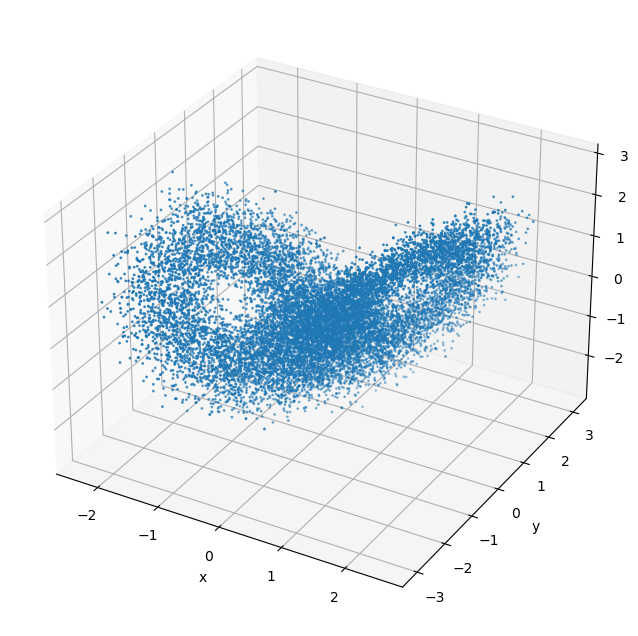

In [30]:
fig, ax = plot_3d_scatter(X_smooth[:, 1:])
plt.show()

In [11]:
model = TcPINN(layers, T, X_pinn=X_pinn, X_semigroup=X_semigroup, X_smooth=X_smooth)

In [ ]:
%%time
               
model.train()

iteration 10, loss: 7.8517, PINN loss: 7.8064, semigroup loss: 0.0000, smoothness loss: 0.0452
iteration 20, loss: 6.7846, PINN loss: 6.7590, semigroup loss: 0.0000, smoothness loss: 0.0256
iteration 30, loss: 6.1312, PINN loss: 6.0479, semigroup loss: 0.0000, smoothness loss: 0.0833
iteration 40, loss: 5.2761, PINN loss: 5.1250, semigroup loss: 0.0000, smoothness loss: 0.1511
iteration 50, loss: 4.1745, PINN loss: 3.9706, semigroup loss: 0.0001, smoothness loss: 0.2038
iteration 60, loss: 3.5054, PINN loss: 3.2597, semigroup loss: 0.0001, smoothness loss: 0.2457
iteration 70, loss: 3.2179, PINN loss: 2.9157, semigroup loss: 0.0001, smoothness loss: 0.3022
iteration 80, loss: 2.8581, PINN loss: 2.5446, semigroup loss: 0.0001, smoothness loss: 0.3134
iteration 90, loss: 2.6950, PINN loss: 2.3704, semigroup loss: 0.0001, smoothness loss: 0.3246
iteration 100, loss: 2.6110, PINN loss: 2.2521, semigroup loss: 0.0001, smoothness loss: 0.3588
iteration 110, loss: 2.5549, PINN loss: 2.1343, s

iteration 870, loss: 0.5267, PINN loss: 0.3319, semigroup loss: 0.0001, smoothness loss: 0.1947
iteration 880, loss: 0.5171, PINN loss: 0.3239, semigroup loss: 0.0001, smoothness loss: 0.1931
iteration 890, loss: 0.5096, PINN loss: 0.3236, semigroup loss: 0.0001, smoothness loss: 0.1860
iteration 900, loss: 0.5012, PINN loss: 0.3231, semigroup loss: 0.0001, smoothness loss: 0.1780
iteration 910, loss: 0.4882, PINN loss: 0.3101, semigroup loss: 0.0001, smoothness loss: 0.1780
iteration 920, loss: 0.4785, PINN loss: 0.3022, semigroup loss: 0.0001, smoothness loss: 0.1763
iteration 930, loss: 0.4714, PINN loss: 0.2913, semigroup loss: 0.0001, smoothness loss: 0.1800
iteration 940, loss: 0.4628, PINN loss: 0.2862, semigroup loss: 0.0001, smoothness loss: 0.1766
iteration 950, loss: 0.4516, PINN loss: 0.2860, semigroup loss: 0.0001, smoothness loss: 0.1656
iteration 960, loss: 0.4387, PINN loss: 0.2763, semigroup loss: 0.0001, smoothness loss: 0.1623
iteration 970, loss: 0.4281, PINN loss: 

iteration 1720, loss: 0.0754, PINN loss: 0.0423, semigroup loss: 0.0000, smoothness loss: 0.0331
iteration 1730, loss: 0.0736, PINN loss: 0.0412, semigroup loss: 0.0000, smoothness loss: 0.0324
iteration 1740, loss: 0.0713, PINN loss: 0.0404, semigroup loss: 0.0000, smoothness loss: 0.0310
iteration 1750, loss: 0.0698, PINN loss: 0.0386, semigroup loss: 0.0000, smoothness loss: 0.0312
iteration 1760, loss: 0.0685, PINN loss: 0.0380, semigroup loss: 0.0000, smoothness loss: 0.0305
iteration 1770, loss: 0.0670, PINN loss: 0.0367, semigroup loss: 0.0000, smoothness loss: 0.0303
iteration 1780, loss: 0.0659, PINN loss: 0.0361, semigroup loss: 0.0000, smoothness loss: 0.0298
iteration 1790, loss: 0.0646, PINN loss: 0.0357, semigroup loss: 0.0000, smoothness loss: 0.0288
iteration 1800, loss: 0.0632, PINN loss: 0.0345, semigroup loss: 0.0000, smoothness loss: 0.0287
iteration 1810, loss: 0.0620, PINN loss: 0.0340, semigroup loss: 0.0000, smoothness loss: 0.0280
iteration 1820, loss: 0.0609, 

iteration 2570, loss: 0.0224, PINN loss: 0.0125, semigroup loss: 0.0000, smoothness loss: 0.0099
iteration 2580, loss: 0.0220, PINN loss: 0.0123, semigroup loss: 0.0000, smoothness loss: 0.0097
iteration 2590, loss: 0.0217, PINN loss: 0.0124, semigroup loss: 0.0000, smoothness loss: 0.0093
iteration 2600, loss: 0.0215, PINN loss: 0.0122, semigroup loss: 0.0000, smoothness loss: 0.0092
iteration 2610, loss: 0.0211, PINN loss: 0.0121, semigroup loss: 0.0000, smoothness loss: 0.0090
iteration 2620, loss: 0.0209, PINN loss: 0.0120, semigroup loss: 0.0000, smoothness loss: 0.0089
iteration 2630, loss: 0.0207, PINN loss: 0.0120, semigroup loss: 0.0000, smoothness loss: 0.0088
iteration 2640, loss: 0.0206, PINN loss: 0.0118, semigroup loss: 0.0000, smoothness loss: 0.0088
iteration 2650, loss: 0.0204, PINN loss: 0.0118, semigroup loss: 0.0000, smoothness loss: 0.0086
iteration 2660, loss: 0.0201, PINN loss: 0.0114, semigroup loss: 0.0000, smoothness loss: 0.0086
iteration 2670, loss: 0.0198, 

iteration 3420, loss: 0.0088, PINN loss: 0.0049, semigroup loss: 0.0000, smoothness loss: 0.0039
iteration 3430, loss: 0.0087, PINN loss: 0.0049, semigroup loss: 0.0000, smoothness loss: 0.0039
iteration 3440, loss: 0.0087, PINN loss: 0.0048, semigroup loss: 0.0000, smoothness loss: 0.0039
iteration 3450, loss: 0.0086, PINN loss: 0.0048, semigroup loss: 0.0000, smoothness loss: 0.0038
iteration 3460, loss: 0.0086, PINN loss: 0.0048, semigroup loss: 0.0000, smoothness loss: 0.0038
iteration 3470, loss: 0.0085, PINN loss: 0.0047, semigroup loss: 0.0000, smoothness loss: 0.0038
iteration 3480, loss: 0.0084, PINN loss: 0.0046, semigroup loss: 0.0000, smoothness loss: 0.0037
iteration 3490, loss: 0.0083, PINN loss: 0.0046, semigroup loss: 0.0000, smoothness loss: 0.0037
iteration 3500, loss: 0.0082, PINN loss: 0.0046, semigroup loss: 0.0000, smoothness loss: 0.0037
iteration 3510, loss: 0.0081, PINN loss: 0.0045, semigroup loss: 0.0000, smoothness loss: 0.0037
iteration 3520, loss: 0.0081, 

iteration 4270, loss: 0.0053, PINN loss: 0.0030, semigroup loss: 0.0000, smoothness loss: 0.0023
iteration 4280, loss: 0.0053, PINN loss: 0.0030, semigroup loss: 0.0000, smoothness loss: 0.0023
iteration 4290, loss: 0.0053, PINN loss: 0.0030, semigroup loss: 0.0000, smoothness loss: 0.0023
iteration 4300, loss: 0.0053, PINN loss: 0.0030, semigroup loss: 0.0000, smoothness loss: 0.0023
iteration 4310, loss: 0.0052, PINN loss: 0.0030, semigroup loss: 0.0000, smoothness loss: 0.0023
iteration 4320, loss: 0.0052, PINN loss: 0.0030, semigroup loss: 0.0000, smoothness loss: 0.0023
iteration 4330, loss: 0.0052, PINN loss: 0.0030, semigroup loss: 0.0000, smoothness loss: 0.0022
iteration 4340, loss: 0.0052, PINN loss: 0.0029, semigroup loss: 0.0000, smoothness loss: 0.0022
iteration 4350, loss: 0.0052, PINN loss: 0.0029, semigroup loss: 0.0000, smoothness loss: 0.0022
iteration 4360, loss: 0.0051, PINN loss: 0.0029, semigroup loss: 0.0000, smoothness loss: 0.0022
iteration 4370, loss: 0.0051, 

iteration 5120, loss: 0.0036, PINN loss: 0.0020, semigroup loss: 0.0000, smoothness loss: 0.0016
iteration 5130, loss: 0.0036, PINN loss: 0.0020, semigroup loss: 0.0000, smoothness loss: 0.0016
iteration 5140, loss: 0.0035, PINN loss: 0.0020, semigroup loss: 0.0000, smoothness loss: 0.0016
iteration 5150, loss: 0.0035, PINN loss: 0.0020, semigroup loss: 0.0000, smoothness loss: 0.0016
iteration 5160, loss: 0.0035, PINN loss: 0.0020, semigroup loss: 0.0000, smoothness loss: 0.0016
iteration 5170, loss: 0.0035, PINN loss: 0.0019, semigroup loss: 0.0000, smoothness loss: 0.0016
iteration 5180, loss: 0.0035, PINN loss: 0.0019, semigroup loss: 0.0000, smoothness loss: 0.0015
iteration 5190, loss: 0.0035, PINN loss: 0.0019, semigroup loss: 0.0000, smoothness loss: 0.0015
iteration 5200, loss: 0.0034, PINN loss: 0.0019, semigroup loss: 0.0000, smoothness loss: 0.0015
iteration 5210, loss: 0.0034, PINN loss: 0.0019, semigroup loss: 0.0000, smoothness loss: 0.0015
iteration 5220, loss: 0.0034, 

iteration 5970, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 5980, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 5990, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 6000, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 6010, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 6020, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 6030, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 6040, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 6050, loss: 0.0025, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 6060, loss: 0.0024, PINN loss: 0.0014, semigroup loss: 0.0000, smoothness loss: 0.0011
iteration 6070, loss: 0.0024, 

iteration 6820, loss: 0.0022, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0010
iteration 6830, loss: 0.0022, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0010
iteration 6840, loss: 0.0022, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0010
iteration 6850, loss: 0.0021, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0010
iteration 6860, loss: 0.0021, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0010
iteration 6870, loss: 0.0021, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0010
iteration 6880, loss: 0.0021, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0009
iteration 6890, loss: 0.0021, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0009
iteration 6900, loss: 0.0021, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0009
iteration 6910, loss: 0.0021, PINN loss: 0.0012, semigroup loss: 0.0000, smoothness loss: 0.0009
iteration 6920, loss: 0.0021, 

iteration 7670, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7680, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7690, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7700, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7710, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7720, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7730, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7740, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7750, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7760, loss: 0.0018, PINN loss: 0.0010, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 7770, loss: 0.0018, 

iteration 8520, loss: 0.0014, PINN loss: 0.0008, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8530, loss: 0.0014, PINN loss: 0.0008, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8540, loss: 0.0014, PINN loss: 0.0008, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8550, loss: 0.0014, PINN loss: 0.0008, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8560, loss: 0.0014, PINN loss: 0.0008, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8570, loss: 0.0014, PINN loss: 0.0008, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8580, loss: 0.0013, PINN loss: 0.0008, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8590, loss: 0.0013, PINN loss: 0.0007, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8600, loss: 0.0013, PINN loss: 0.0007, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8610, loss: 0.0013, PINN loss: 0.0007, semigroup loss: 0.0000, smoothness loss: 0.0006
iteration 8620, loss: 0.0013, 

iteration 9370, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9380, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9390, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9400, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9410, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9420, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9430, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9440, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9450, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9460, loss: 0.0011, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0005
iteration 9470, loss: 0.0011, 

iteration 10220, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10230, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10240, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10250, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10260, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10270, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10280, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10290, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10300, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10310, loss: 0.0010, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0004
iteration 10320, los

iteration 11060, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11070, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11080, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11090, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11100, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11110, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11120, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11130, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11140, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11150, loss: 0.0008, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11160, los

iteration 11900, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11910, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11920, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11930, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11940, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11950, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11960, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11970, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11980, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 11990, loss: 0.0007, PINN loss: 0.0004, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12000, los

iteration 12740, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12750, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12760, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12770, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12780, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12790, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12800, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12810, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12820, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12830, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 12840, los

iteration 13580, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13590, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13600, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13610, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13620, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13630, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13640, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13650, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13660, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13670, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 13680, los

iteration 14420, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14430, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14440, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14450, loss: 0.0006, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14460, loss: 0.0005, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14470, loss: 0.0005, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14480, loss: 0.0005, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14490, loss: 0.0005, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14500, loss: 0.0005, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14510, loss: 0.0005, PINN loss: 0.0003, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 14520, los

In [ ]:
with open("./model_lorenz.pkl", "wb") as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./model_lorenz.pkl", "rb") as f:
    model = pickle.load(f)

## Predict and Plot the Solution

In [ ]:
def plot_3d_curve(sol):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    ax.plot(sol[:, 0], sol[:, 1], sol[:, 2], lw=1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    return fig, ax

In [ ]:
# Note that max_t in training is .1
y0 = init_values[0]

max_t_pred = 10.
delta_t = 0.01

validation_tc = model.predict_tc(max_t_pred, delta_t, y0)

In [ ]:
fig, ax = plot_3d_curve(validation_tc)

plt.savefig("lorenz_system.pdf", bbox_inches="tight")
plt.show()